# Wrangle and Analyze Data - Project 4
by Joel Nsadha

## Table of Contents
- [I.Introduction](#intro)
- [II.Gathering Data](#gather)
- [III.Assessing Data](#assess)
- [IV.Cleaning Data](#clean)
- [V.Analyzing Data & Visualization](#analyze)


<a id='intro'></a>
## I. Introduction

Data wrangling involves gathering, assesssing data visually and progratically, and cleaning it for analysis. 
In this data wrangling project, we aim to explore and analyze Twitter data related to dog ratings. The dataset, sourced from Twitter's platform, contains various information about dogs including their images, ratings given by users, and additional details such as dog breeds and names. Our objective is to gather, assess, and clean the data to ensure its quality and usability for further analysis. 

<a id='gather'></a>
## II. Gathering Data

Gather each of the three pieces of data from different sources:
- We get the tweets data from a .csv file`twitter_archive_enhanced.csv`
- Tweet image predictions from a .tsv file`image_predictions.tsv` 
- Teet counts and favorites from .txt file `tweet_json.txt` 


In [2]:
import pandas as pd
import numpy as np
from datetime import datetime as dt
import requests
import json
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

### 1. WeRateDogs Twitter Archive
For this section, we read the .csv file using the Pandas library

In [3]:
# Read CSV file using Pandas library
twitter_archive = pd.read_csv('twitter-archive-enhanced.csv')

### 2. Tweet Image Predictions
We read the second dataset that includes image predictions that have been run thorugh a machine learning model to predict whether each image is a dog and what type of breed it is.

In [4]:
# Access the image predictions file using the Requests library. Response should be 200 to indicate success
url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
response = requests.get(url)
response

<Response [200]>

In [5]:
# save the file as a .tsv and read it's contents using pandas
with open('image-predictions.tsv', mode = 'wb') as file:
    file.write(response.content)
    
# Read TSV file
image_prediction = pd.read_csv('image-predictions.tsv', sep = '\t')

image_prediction.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


### 3. Twitter API 
The third and last dataset is from a Twitter API that includes the retweet counts and favourite (likes) counts on all the original tweets.

In [6]:
# We read the API data using Requests library and store it's contents into a text file
url = 'https://video.udacity-data.com/topher/2018/November/5be5fb7d_tweet-json/tweet-json.txt'
response = requests.get(url)

# Save the file
with open('tweet-json.txt', mode = 'wb') as file:
    file.write(response.content)

In [7]:
# Read the saved .txt file line by line and create a pandas DataFrame using Pandas library
rows = []
with open('tweet-json.txt', 'r') as file:
    lines = file.readlines()
    for line in lines:
        rows.append(json.loads(line))

# lists of fields we will create into a DataFrame
tweet_ids = []
retweet_counts = []
favorite_counts = []

# Extract and append to each list
for i in rows:
    tweet_ids.append(i.get('id'))
    retweet_counts.append(i.get('retweet_count'))
    favorite_counts.append(i.get('favorite_count'))
    
retweet_data = {'tweet_id': tweet_ids,
                'retweet_count': retweet_counts,
                'favorite_counts': favorite_counts
               }

tweet_count = pd.DataFrame(retweet_data)

<a id='assess'></a>
## III. Assessing Data

In assessing data, we look at two main things. 
- Data Quality: We identify areas in which data accuracy, validity, completeness and consistency are lacking 
- Data Tidiness: We check to ensure that each variabe formas a column and each observational unit forms a table. Also we ensure that each observation forms a row.
The data assessment is both visual, as well as programatic using the Pandas library. 


### twitter_archive table assessment - Visual Assessment

In [8]:
# Open dataset for visual assessment to determine what needs to be fixed
twitter_archive

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2351,666049248165822465,NaN,NaN,2015-11-16 00:24:50 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a 1949 1st generation vulpix. Enj...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666049248...,5,10,None,None,None,None,None
2352,666044226329800704,NaN,NaN,2015-11-16 00:04:52 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a purebred Piers Morgan. Loves to Netf...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666044226...,6,10,a,None,None,None,None
2353,666033412701032449,NaN,NaN,2015-11-15 23:21:54 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here is a very happy pup. Big fan of well-main...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666033412...,9,10,a,None,None,None,None
2354,666029285002620928,NaN,NaN,2015-11-15 23:05:30 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a western brown Mitsubishi terrier. Up...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666029285...,7,10,a,None,None,None,None


In [9]:
# Getting a programatic overview of the dataset and each column
twitter_archive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        2356 non-null   object 
 13  doggo                       2356 

## Defining functions for quicker programatic assessment
After visually assessign the dataset and showing the info for each field, we can define functions to make the programatic assesment quicker, effecient and cleaner.



In [10]:
class Assesser:
    """
    Class with methods that help to programmatically assess any dataset
    In the form of a Pandas DataFrame.
    """

    def __init__(self, df):
        """
        Initializes a Pandas DataFrame that will be programmatically assessed.

        Parameters:
        - df (pd.DataFrame): The Pandas DataFrame to be assessed.
        """
        self.df = df

    def get_value_counts(self, columns):
        """
        Takes columns of a DataFrame

        Parameters:
        - columns (list or str): The column(s) for which value counts will be calculated.
          If a single column is provided as a string, it will be converted to a list.

        Example:
        ```
        assessor = Assesser(my_dataframe)
        assessor.get_value_counts(['column1', 'column2'])
        ```
        """
        print(self.df[columns].value_counts())

    def get_duplicates(self, columns=None):
        """
        Checks for duplicates in the dataset.

        Parameters:
        - columns (list or str, optional): The column(s) to check for duplicates.
          If not provided, duplicates in the entire dataset will be checked.

        Returns:
        - pd.DataFrame: DataFrame containing duplicates based on the specified columns,
          or the entire dataset if no columns are specified.
        """
        if columns is None:
            print(self.df.duplicated().sum())
        else:
            print(self.df.duplicated(subset=columns).sum())

    def count_null_values(self):
        """
        Prints the count of null values for each column in the DataFrame.
        """
        print(self.df.isnull().sum())

    def check_denominator(self, operator, comparison_value):
        """
        Returns a DataFrame with entries that satisfy the specified condition based on the rating_denominator column.

        Parameters:
        - operator (str): The comparison operator (e.g., '>', '<', '==').
        - comparison_value: The value to compare against.

        Returns:
        - pd.DataFrame: DataFrame containing entries that match the specified condition.
          Columns are the same as the original DataFrame.
        """
        result = self.df.query(f"rating_denominator {operator} {comparison_value}")
        if result is not None:
            return pd.DataFrame(result, columns=self.df.columns)
        else:
            print("Did not return any values")

    def check_numerator(self, operator, comparison_value):
        """
        Returns a DataFrame with entries that satisfy the specified condition based on the rating_numerator column.

        Parameters:
        - operator (str): The comparison operator (e.g., '>', '<', '==').
        - comparison_value: The value to compare against.

        Returns:
        - pd.DataFrame: DataFrame containing entries that match the specified condition.
          Columns are the same as the original DataFrame.
        """
        result = self.df.query(f"rating_numerator {operator} {comparison_value}")
        if result is not None:
            return pd.DataFrame(result, columns=self.df.columns)
        else:
            print("Did not return any values")
            
    def check_confidence(self, confidence_field, operator, level):
        result = self.df.query(f"{confidence_field} {operator} {level}") 
        if result is not None:
            return pd.DataFrame(result, columns=self.df.columns)
        else:
            print("Did not return any values")
            
    def get_dogs(self, field):
        return self.df.query(f"{field}")


## Programatic Assessment

In [11]:
# Instantiate the Assesser class that we will use to assess the dataset
twitter_data = Assesser(twitter_archive)

In [12]:
# Checks and returns a sun of duplicate rows within the entire dataset
twitter_data.get_duplicates()

0


In [13]:
# Check for duplicates in the tween_id field
twitter_data.get_duplicates('tweet_id')

0


In [14]:
# Check the value counts and accurances within the numerator and denominator fields. Combining them makes it easier to see combinations that are inaccurate
twitter_data.get_value_counts(['rating_numerator', 'rating_denominator'])

rating_numerator  rating_denominator
12                10                    558
11                10                    463
10                10                    461
13                10                    351
9                 10                    156
8                 10                    102
7                 10                     54
14                10                     54
5                 10                     37
6                 10                     32
3                 10                     19
4                 10                     15
2                 10                      9
1                 10                      8
420               10                      2
15                10                      2
0                 10                      2
9                 11                      2
4                 20                      2
75                10                      2
666               10                      1
84                70                   

In [15]:
# Check the distribution of data sources
twitter_data.get_value_counts('source')

<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>     2221
<a href="http://vine.co" rel="nofollow">Vine - Make a Scene</a>                          91
<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>                       33
<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>      11
Name: source, dtype: int64


In [16]:
# Check how many ratings have numerator less than the standard denominator of 10. These may be errors
twitter_data.check_numerator('<', 10).tweet_id.count()

440

In [17]:
# Check how many ratings are greater than 50. These may be in error
twitter_data.check_numerator('>', 50).tweet_id.count()

18

In [18]:
# Check how many denominators are less than the baseline standard rating of 10
twitter_data.check_denominator('<', 10).tweet_id.count()

3

In [19]:
# Check how many denominator ratings are greater than the baseline standard rating of 10
twitter_data.check_denominator('>', 10).tweet_id.count()

20

In [20]:
# Checking for Null values within the dataset
twitter_data.count_null_values()

tweet_id                         0
in_reply_to_status_id         2278
in_reply_to_user_id           2278
timestamp                        0
source                           0
text                             0
retweeted_status_id           2175
retweeted_status_user_id      2175
retweeted_status_timestamp    2175
expanded_urls                   59
rating_numerator                 0
rating_denominator               0
name                             0
doggo                            0
floofer                          0
pupper                           0
puppo                            0
dtype: int64


**Observations:**
- Filter out any retweets and retain only original tweets. We need only original ratings with pictures.
- The timestamp is recorded as a string and needs to be converted by removing +0000
- In the denominator field, there are abnormal values e.g values way over 10 or under 10. 
- In the numerator field, there are abnormal values e.g values way over 10 or under 10. 
- Turn all fields to lower case and uniform.


### image_prediction table - Visual Assessment

In [21]:
image_prediction

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True
...,...,...,...,...,...,...,...,...,...,...,...,...
2070,891327558926688256,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,2,basset,0.555712,True,English_springer,0.225770,True,German_short-haired_pointer,0.175219,True
2071,891689557279858688,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,1,paper_towel,0.170278,False,Labrador_retriever,0.168086,True,spatula,0.040836,False
2072,891815181378084864,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,1,Chihuahua,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True
2073,892177421306343426,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1,Chihuahua,0.323581,True,Pekinese,0.090647,True,papillon,0.068957,True


## Programatic Assessment

In [22]:
image_prediction.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  2075 non-null   int64  
 1   jpg_url   2075 non-null   object 
 2   img_num   2075 non-null   int64  
 3   p1        2075 non-null   object 
 4   p1_conf   2075 non-null   float64
 5   p1_dog    2075 non-null   bool   
 6   p2        2075 non-null   object 
 7   p2_conf   2075 non-null   float64
 8   p2_dog    2075 non-null   bool   
 9   p3        2075 non-null   object 
 10  p3_conf   2075 non-null   float64
 11  p3_dog    2075 non-null   bool   
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [23]:
image_prediction.describe()

,tweet_id,img_num,p1_conf,p2_conf,p3_conf
count,2.075000e+03,2075.000000,2075.000000,2.075000e+03,2.075000e+03
mean,7.384514e+17,1.203855,0.594548,1.345886e-01,6.032417e-02
std,6.785203e+16,0.561875,0.271174,1.006657e-01,5.090593e-02
min,6.660209e+17,1.000000,0.044333,1.011300e-08,1.740170e-10
25%,6.764835e+17,1.000000,0.364412,5.388625e-02,1.622240e-02
50%,7.119988e+17,1.000000,0.588230,1.181810e-01,4.944380e-02
75%,7.932034e+17,1.000000,0.843855,1.955655e-01,9.180755e-02
max,8.924206e+17,4.000000,1.000000,4.880140e-01,2.734190e-01


In [24]:
# Instantiate Assessor class for image data
image_data = Assesser(image_prediction)

In [25]:
# Check for duplicate values
image_data.get_duplicates()

0


In [26]:
# Check for the value counts
print(image_data.get_value_counts(['p1']), image_data.get_value_counts(['p2']), image_data.get_value_counts(['p3']), end=" ")

p1                
golden_retriever      150
Labrador_retriever    100
Pembroke               89
Chihuahua              83
pug                    57
                     ... 
hay                     1
hotdog                  1
hummingbird             1
ibex                    1
zebra                   1
Length: 378, dtype: int64
p2                
Labrador_retriever    104
golden_retriever       92
Cardigan               73
Chihuahua              44
Pomeranian             42
                     ... 
hyena                   1
iPod                    1
ice_lolly               1
indri                   1
wood_rabbit             1
Length: 405, dtype: int64
p3                
Labrador_retriever    79
Chihuahua             58
golden_retriever      48
Eskimo_dog            38
kelpie                35
                      ..
ibex                   1
jaguar                 1
jeep                   1
jersey                 1
zebra                  1
Length: 408, dtype: int64
None None None 

In [27]:
# Check predictions that are True
image_data.get_dogs('p1_dog')

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True
...,...,...,...,...,...,...,...,...,...,...,...,...
2068,890971913173991426,https://pbs.twimg.com/media/DF1eOmZXUAALUcq.jpg,1,Appenzeller,0.341703,True,Border_collie,0.199287,True,ice_lolly,0.193548,False
2069,891087950875897856,https://pbs.twimg.com/media/DF3HwyEWsAABqE6.jpg,1,Chesapeake_Bay_retriever,0.425595,True,Irish_terrier,0.116317,True,Indian_elephant,0.076902,False
2070,891327558926688256,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,2,basset,0.555712,True,English_springer,0.225770,True,German_short-haired_pointer,0.175219,True
2072,891815181378084864,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,1,Chihuahua,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True


In [28]:
# Check prediction confidence level above average
image_data.check_confidence('p1_conf', '>=', 0.5)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True
5,666050758794694657,https://pbs.twimg.com/media/CT5Jof1WUAEuVxN.jpg,1,Bernese_mountain_dog,0.651137,True,English_springer,0.263788,True,Greater_Swiss_Mountain_dog,0.016199,True
6,666051853826850816,https://pbs.twimg.com/media/CT5KoJ1WoAAJash.jpg,1,box_turtle,0.933012,False,mud_turtle,0.045885,False,terrapin,0.017885,False
...,...,...,...,...,...,...,...,...,...,...,...,...
2064,890006608113172480,https://pbs.twimg.com/media/DFnwSY4WAAAMliS.jpg,1,Samoyed,0.957979,True,Pomeranian,0.013884,True,chow,0.008167,True
2065,890240255349198849,https://pbs.twimg.com/media/DFrEyVuW0AAO3t9.jpg,1,Pembroke,0.511319,True,Cardigan,0.451038,True,Chihuahua,0.029248,True
2067,890729181411237888,https://pbs.twimg.com/media/DFyBahAVwAAhUTd.jpg,2,Pomeranian,0.566142,True,Eskimo_dog,0.178406,True,Pembroke,0.076507,True
2070,891327558926688256,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,2,basset,0.555712,True,English_springer,0.225770,True,German_short-haired_pointer,0.175219,True


In [29]:
image_data.get_duplicates('jpg_url')

66


**Obervatoins:**

- There are observations within the dataset that are not dogs. 
- This data is part of the same observation unit as the tweets.
- There are predictions that have very low confidence levels.

### tweet_json table - Visual Assessment

In [30]:
tweet_count

,tweet_id,retweet_count,favorite_counts
0,892420643555336193,8853,39467
1,892177421306343426,6514,33819
2,891815181378084864,4328,25461
3,891689557279858688,8964,42908
4,891327558926688256,9774,41048
...,...,...,...
2349,666049248165822465,41,111
2350,666044226329800704,147,311
2351,666033412701032449,47,128
2352,666029285002620928,48,132


## Programatic Assessment

In [31]:
tweet_count_data = Assesser(tweet_count)

In [32]:
tweet_count.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2354 entries, 0 to 2353
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype
---  ------           --------------  -----
 0   tweet_id         2354 non-null   int64
 1   retweet_count    2354 non-null   int64
 2   favorite_counts  2354 non-null   int64
dtypes: int64(3)
memory usage: 55.3 KB


In [33]:
tweet_count.describe()

,tweet_id,retweet_count,favorite_counts
count,2.354000e+03,2354.000000,2354.000000
mean,7.426978e+17,3164.797366,8080.968564
std,6.852812e+16,5284.770364,11814.771334
min,6.660209e+17,0.000000,0.000000
25%,6.783975e+17,624.500000,1415.000000
50%,7.194596e+17,1473.500000,3603.500000
75%,7.993058e+17,3652.000000,10122.250000
max,8.924206e+17,79515.000000,132810.000000


In [34]:
# Check duplicate tweet id's
tweet_count_data.get_duplicates('tweet_id')

0


In [35]:
# Check for null values
tweet_count_data.count_null_values()

tweet_id           0
retweet_count      0
favorite_counts    0
dtype: int64


### Observations:

#### Quality
1. Filter out any retweets and retain only original tweets. Data includes replies and retweets
2. Combine dog stages into one column
3. The timestamp is recorded as a string and needs to be converted by removing +0000
4. In the denominator field, there are abnormal values e.g values way over 10 or under 10. 
5. In the numerator field, there are abnormal values e.g values way over 10 or under 10. 
6. There are observations that are not dogs.
7. Field headers need to be lower case data and merge images. 
8. Extract the source.
9. Add tweet count and remove URLs.
10. Capitalize dog names

#### Tidiness
- The tables are all related and should belong in the same dataset.
- Make all field titles lowercase and uniform

<a id='clean'></a>
## IV.Cleaning Data

Data cleaning will follow the following three steps:

- Define: we define the cleaning tasks based on our assessments. 
- Code: We clean the data programatically using code.
- Test: We test to ensure that the code provided the desired result.



In [36]:
# We make copies of the datasets
tweets_clean = twitter_archive.copy()
image_clean = image_prediction.copy()
tweet_count_clean = tweet_count.copy()

### Data Quality

#### 1. Filter out any retweets and retain only original tweets. We need to remove replies and retweets.

In [37]:
# Exclude any replies and retweets from the data
tweets_clean = tweets_clean[tweets_clean.in_reply_to_status_id.isnull()]
tweets_clean = tweets_clean[tweets_clean.in_reply_to_user_id.isnull()]
tweets_clean = tweets_clean[tweets_clean.retweeted_status_id.isnull()]
tweets_clean = tweets_clean[tweets_clean.retweeted_status_user_id.isnull()]
tweets_clean = tweets_clean[tweets_clean.retweeted_status_timestamp.isnull()]

In [38]:
# Check to ensure there are no replies included. Value counts should return nothing because replies are all NaN
tweets_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2097 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2097 non-null   int64  
 1   in_reply_to_status_id       0 non-null      float64
 2   in_reply_to_user_id         0 non-null      float64
 3   timestamp                   2097 non-null   object 
 4   source                      2097 non-null   object 
 5   text                        2097 non-null   object 
 6   retweeted_status_id         0 non-null      float64
 7   retweeted_status_user_id    0 non-null      float64
 8   retweeted_status_timestamp  0 non-null      object 
 9   expanded_urls               2094 non-null   object 
 10  rating_numerator            2097 non-null   int64  
 11  rating_denominator          2097 non-null   int64  
 12  name                        2097 non-null   object 
 13  doggo                       2097 

In [39]:
tweets_clean.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


In [191]:
# Drop columns relating to replies and retweets
replies_retweets = [x for x in list(tweets_clean) if 'reply' in str(x).lower() or 'retweet' in str(x).lower()]
tweets_clean.drop(columns=replies_retweets, inplace=True)

In [192]:
# Check to make sure replies and retweets were removed
tweets_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2097 entries, 0 to 2355
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   tweet_id            2097 non-null   int64 
 1   timestamp           2097 non-null   object
 2   source              2097 non-null   object
 3   text                2097 non-null   object
 4   expanded_urls       2094 non-null   object
 5   rating_numerator    2097 non-null   int64 
 6   rating_denominator  2097 non-null   int64 
 7   name                2097 non-null   object
 8   doggo               2097 non-null   object
 9   floofer             2097 non-null   object
 10  pupper              2097 non-null   object
 11  puppo               2097 non-null   object
dtypes: int64(3), object(9)
memory usage: 213.0+ KB


#### 2. Combine dog types and remove old columns

In [58]:
# Check dog stages
tweets_clean.doggo.value_counts()

None     2014
doggo      83
Name: doggo, dtype: int64

In [59]:
tweets_clean.floofer.value_counts()

None       2087
floofer      10
Name: floofer, dtype: int64

In [60]:
tweets_clean.pupper.value_counts()

None      1867
pupper     230
Name: pupper, dtype: int64

In [61]:
tweets_clean.puppo.value_counts()

None     2073
puppo      24
Name: puppo, dtype: int64

In [62]:

make_dummy = lambda x: 0 if x == 'None' else 1

tweets_clean.doggo = tweets_clean.doggo.apply(make_dummy)
tweets_clean.floofer = tweets_clean.floofer.apply(make_dummy)
tweets_clean.pupper = tweets_clean.pupper.apply(make_dummy)
tweets_clean.puppo = tweets_clean.puppo.apply(make_dummy)

tweets_clean['none'] = tweets_clean['doggo'] + tweets_clean['floofer'] + \
                        tweets_clean['pupper'] + tweets_clean['puppo']

tweets_clean['none'].value_counts()



0    1761
1     325
2      11
Name: none, dtype: int64

In [63]:
stage_none = lambda x: 1 if x == 0 else 0

tweets_clean['none'] = tweets_clean['none'].apply(stage_none)

stage = ['floofer', 'puppo', 'doggo', 'pupper', 'none']

conditions = [
    (tweets_clean[stage[0]] == 1),
    (tweets_clean[stage[1]] == 1),
    (tweets_clean[stage[2]] == 1),
    (tweets_clean[stage[3]] == 1),
    (tweets_clean[stage[4]] == 1)]

tweets_clean['stage'] = np.select(conditions, stage, default = stage[4])

tweets_clean.drop(stage, axis = 1, inplace = True)

tweets_clean['stage'] = tweets_clean.stage.astype('category')


In [65]:
tweets_clean.head(5)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,stage
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,none
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,none
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,none
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,none
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,none


#### 3. The timestamp is recorded as a string and needs to be converted by removing +0000

In [193]:
# Convert timestamp from string to a timestamp
tweets_clean.timestamp = tweets_clean.timestamp.apply(lambda x: pd.to_datetime(x[:-6]))

In [194]:
# Check the change
tweets_clean.timestamp.info()

<class 'pandas.core.series.Series'>
Int64Index: 2097 entries, 0 to 2355
Series name: timestamp
Non-Null Count  Dtype         
--------------  -----         
2097 non-null   datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 32.8 KB


#### 4. Remove any denominators over or under 10. 


In [195]:
# Remove Denominator values that are under 10 and over 10
tweets_clean = tweets_clean.query("rating_denominator >= 10 & rating_denominator < 11")

In [196]:
# Verify denominator
tweets_clean.query("rating_denominator > 10 & rating_denominator < 10")

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo


#### 5. Remove any numerators under 10 and any nuerators that are abnormally over 10. 


In [197]:
# Remove Numerator values that are under 10 or abonormally over 10
tweets_clean = tweets_clean.query("rating_numerator >= 10  & rating_numerator < 20")

In [198]:
# vreify numerator
tweets_clean.query("rating_numerator < 10  & rating_numerator > 20")

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo


In [66]:
tweets_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2097 entries, 0 to 2355
Data columns (total 14 columns):
 #   Column                      Non-Null Count  Dtype   
---  ------                      --------------  -----   
 0   tweet_id                    2097 non-null   int64   
 1   in_reply_to_status_id       0 non-null      float64 
 2   in_reply_to_user_id         0 non-null      float64 
 3   timestamp                   2097 non-null   object  
 4   source                      2097 non-null   object  
 5   text                        2097 non-null   object  
 6   retweeted_status_id         0 non-null      float64 
 7   retweeted_status_user_id    0 non-null      float64 
 8   retweeted_status_timestamp  0 non-null      object  
 9   expanded_urls               2094 non-null   object  
 10  rating_numerator            2097 non-null   int64   
 11  rating_denominator          2097 non-null   int64   
 12  name                        2097 non-null   object  
 13  stage             

#### 6. Remove observations that are not dogs


In [70]:
# Proof that p1 confidence is always higher that p2 confidence. So we will use p1 confidence
image_clean.query("p1_conf < p2_conf")

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog


In [71]:
# Find any observations that are not dogs
not_dogs = image_clean.query("p1_dog == False & p2_dog == False & p3_dog == False")
not_dogs.index

Int64Index([   6,   17,   18,   21,   25,   29,   45,   50,   51,   53,
            ...
            1953, 1956, 1975, 1979, 2012, 2021, 2022, 2046, 2052, 2074],
           dtype='int64', length=324)

In [72]:
# Delete observations that are not dogs from datasets
image_clean.drop(not_dogs.index, inplace=True)

In [73]:
image_clean.drop(image_clean.query("p1_dog == False").index, inplace=True)

#### 7. Merge images and tweets

In [74]:
result_df = pd.merge(tweets_clean, image_clean, on='tweet_id', how='left')

In [75]:
result_df.head(3)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,...,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,...,1.0,Chihuahua,0.323581,True,Pekinese,0.090647,True,papillon,0.068957,True
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,...,1.0,Chihuahua,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True


#### 8. Extract tweet source

In [76]:
# Seperate each source
result_df.source = result_df['source'].str.extract('^<a.+>(.+)</a>$')

In [77]:
result_df.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,...,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,Twitter for iPhone,This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,Twitter for iPhone,This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,...,1.0,Chihuahua,0.323581,True,Pekinese,0.090647,True,papillon,0.068957,True
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,Twitter for iPhone,This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,...,1.0,Chihuahua,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,Twitter for iPhone,This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,Twitter for iPhone,This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,...,2.0,basset,0.555712,True,English_springer,0.225770,True,German_short-haired_pointer,0.175219,True


In [78]:
# Drop undesired columns
cols_to_drop = ['jpg_url', 'img_num', 'p2', 'p2_conf', 'p2_dog', 'p3', 'p3_conf', 'p3_dog', 'in_reply_to_status_id', 'in_reply_to_user_id']
result_df.drop(columns=cols_to_drop, inplace=True)

In [82]:
result_df.drop(columns=['retweeted_status_id', 'retweeted_status_user_id', 'retweeted_status_timestamp'], inplace=True)

In [84]:
# Drop rows that do not have a breed prediction
result_df.drop(result_df[result_df.p1.isna()].index, inplace=True)

In [87]:
result_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1463 entries, 1 to 2096
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   tweet_id            1463 non-null   int64   
 1   timestamp           1463 non-null   object  
 2   source              1463 non-null   object  
 3   text                1463 non-null   object  
 4   expanded_urls       1463 non-null   object  
 5   rating_numerator    1463 non-null   int64   
 6   rating_denominator  1463 non-null   int64   
 7   name                1463 non-null   object  
 8   stage               1463 non-null   category
 9   p1                  1463 non-null   object  
 10  p1_conf             1463 non-null   float64 
 11  p1_dog              1463 non-null   object  
dtypes: category(1), float64(1), int64(3), object(7)
memory usage: 138.8+ KB


#### 9. Add tweet counts to dataset

In [88]:
final_data = pd.merge(result_df, tweet_count_clean, on='tweet_id', how='inner')

In [89]:
# Check for null values
final_data.isna().sum()

tweet_id              0
timestamp             0
source                0
text                  0
expanded_urls         0
rating_numerator      0
rating_denominator    0
name                  0
stage                 0
p1                    0
p1_conf               0
p1_dog                0
retweet_count         0
favorite_counts       0
dtype: int64

In [90]:
final_data.head()

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,stage,p1,p1_conf,p1_dog,retweet_count,favorite_counts
0,892177421306343426,2017-08-01 00:17:27 +0000,Twitter for iPhone,This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,none,Chihuahua,0.323581,True,6514,33819
1,891815181378084864,2017-07-31 00:18:03 +0000,Twitter for iPhone,This is Archie. He is a rare Norwegian Pouncin...,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,none,Chihuahua,0.716012,True,4328,25461
2,891327558926688256,2017-07-29 16:00:24 +0000,Twitter for iPhone,This is Franklin. He would like you to stop ca...,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,none,basset,0.555712,True,9774,41048
3,891087950875897856,2017-07-29 00:08:17 +0000,Twitter for iPhone,Here we have a majestic great white breaching ...,https://twitter.com/dog_rates/status/891087950...,13,10,None,none,Chesapeake_Bay_retriever,0.425595,True,3261,20562
4,890971913173991426,2017-07-28 16:27:12 +0000,Twitter for iPhone,Meet Jax. He enjoys ice cream so much he gets ...,"https://gofundme.com/ydvmve-surgery-for-jax,ht...",13,10,Jax,none,Appenzeller,0.341703,True,2158,12041


In [100]:
#Drop expanded URL
final_data.drop(columns = ['expanded_urls'], inplace=True)

#### 10. Capitalize Names and breeds

In [101]:
# Capitalize Names
final_data.name = final_data.name.apply(lambda x: x.capitalize())
final_data.p1 = final_data.p1.apply(lambda x: x.capitalize())

AttributeError: 'DataFrame' object has no attribute 'p1'

#### 10. Rename columns

In [102]:
final_data.rename(columns={'tweet_id': 'tweet_id', 
                          'timestamp': 'timestamp',
                          'source': 'source',
                          'rating_numerator': 'numerator',
                          'rating_denominator': 'denominator',
                          'name': 'name',
                          'p1': 'breed',
                          'p1_conf': 'confidence',
                          'p1_dog': 'dog',
                          'retweet_count': 'retweet_count',
                          'favorite_counts': 'likes'}, inplace=True)

In [103]:
# The final dataset
final_data.head(20)

,tweet_id,timestamp,source,text,numerator,denominator,name,stage,breed,confidence,dog,retweet_count,likes
0,892177421306343426,2017-08-01 00:17:27 +0000,Twitter for iPhone,This is Tilly. She's just checking pup on you....,13,10,Tilly,none,Chihuahua,0.323581,True,6514,33819
1,891815181378084864,2017-07-31 00:18:03 +0000,Twitter for iPhone,This is Archie. He is a rare Norwegian Pouncin...,12,10,Archie,none,Chihuahua,0.716012,True,4328,25461
2,891327558926688256,2017-07-29 16:00:24 +0000,Twitter for iPhone,This is Franklin. He would like you to stop ca...,12,10,Franklin,none,Basset,0.555712,True,9774,41048
3,891087950875897856,2017-07-29 00:08:17 +0000,Twitter for iPhone,Here we have a majestic great white breaching ...,13,10,None,none,Chesapeake_bay_retriever,0.425595,True,3261,20562
4,890971913173991426,2017-07-28 16:27:12 +0000,Twitter for iPhone,Meet Jax. He enjoys ice cream so much he gets ...,13,10,Jax,none,Appenzeller,0.341703,True,2158,12041
5,890729181411237888,2017-07-28 00:22:40 +0000,Twitter for iPhone,When you watch your owner call another dog a g...,13,10,None,none,Pomeranian,0.566142,True,16716,56848
6,890609185150312448,2017-07-27 16:25:51 +0000,Twitter for iPhone,This is Zoey. She doesn't want to be one of th...,13,10,Zoey,none,Irish_terrier,0.487574,True,4429,28226
7,890240255349198849,2017-07-26 15:59:51 +0000,Twitter for iPhone,This is Cassie. She is a college pup. Studying...,14,10,Cassie,doggo,Pembroke,0.511319,True,7711,32467
8,890006608113172480,2017-07-26 00:31:25 +0000,Twitter for iPhone,This is Koda. He is a South Australian decksha...,13,10,Koda,none,Samoyed,0.957979,True,7624,31166
9,889880896479866881,2017-07-25 16:11:53 +0000,Twitter for iPhone,This is Bruno. He is a service shark. Only get...,13,10,Bruno,none,French_bulldog,0.377417,True,5156,28268


### Store the clean dataframe - txt and csv

In [104]:
final_data.to_csv('twitter_archive_master.csv', index = False)

In [105]:
# load data to a dataframe
df = pd.read_csv('twitter_archive_master.csv')
df.head()

,tweet_id,timestamp,source,text,numerator,denominator,name,stage,breed,confidence,dog,retweet_count,likes
0,892177421306343426,2017-08-01 00:17:27 +0000,Twitter for iPhone,This is Tilly. She's just checking pup on you....,13,10,Tilly,none,Chihuahua,0.323581,True,6514,33819
1,891815181378084864,2017-07-31 00:18:03 +0000,Twitter for iPhone,This is Archie. He is a rare Norwegian Pouncin...,12,10,Archie,none,Chihuahua,0.716012,True,4328,25461
2,891327558926688256,2017-07-29 16:00:24 +0000,Twitter for iPhone,This is Franklin. He would like you to stop ca...,12,10,Franklin,none,Basset,0.555712,True,9774,41048
3,891087950875897856,2017-07-29 00:08:17 +0000,Twitter for iPhone,Here we have a majestic great white breaching ...,13,10,None,none,Chesapeake_bay_retriever,0.425595,True,3261,20562
4,890971913173991426,2017-07-28 16:27:12 +0000,Twitter for iPhone,Meet Jax. He enjoys ice cream so much he gets ...,13,10,Jax,none,Appenzeller,0.341703,True,2158,12041


<a id='analyze'></a>
## V.Analyzing Data & Visualization

### Analyses to explore:
- The most submitted breeds
- What is teh relationship between retweet counts and number of likes?
- What is the relationship between time of the day and the tweets
- How many retweets and likes per tweet based on the hour of the day?
- Most popular breeds based on favorites or likes

In [106]:
df.breed.value_counts()

Golden_retriever      137
Labrador_retriever     94
Pembroke               88
Chihuahua              78
Pug                    54
                     ... 
Scotch_terrier          1
Entlebucher             1
Japanese_spaniel        1
Standard_schnauzer      1
Clumber                 1
Name: breed, Length: 111, dtype: int64

##### 1. The most submitted breeds
We would like to know what the most popular breeds are by the number of dogs submutted 

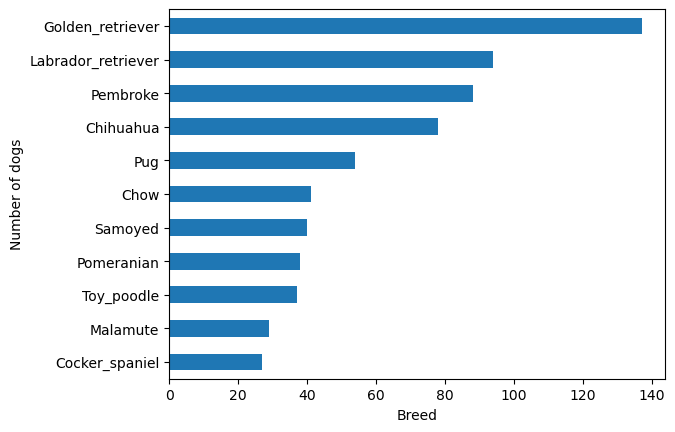

In [107]:
df.breed.value_counts()[10::-1].plot(kind='barh')
plt.xlabel('Breed')
plt.ylabel('Number of dogs');

#### Observation
From the above chart, we can see that the Golden Retriever is the most popular dog based on the number of rated dogs followed by the Labrador Retriever.

##### 2. The relationship between likes and retweets
We would like to indetify what type of relationship there is between favorites or likes and retweets

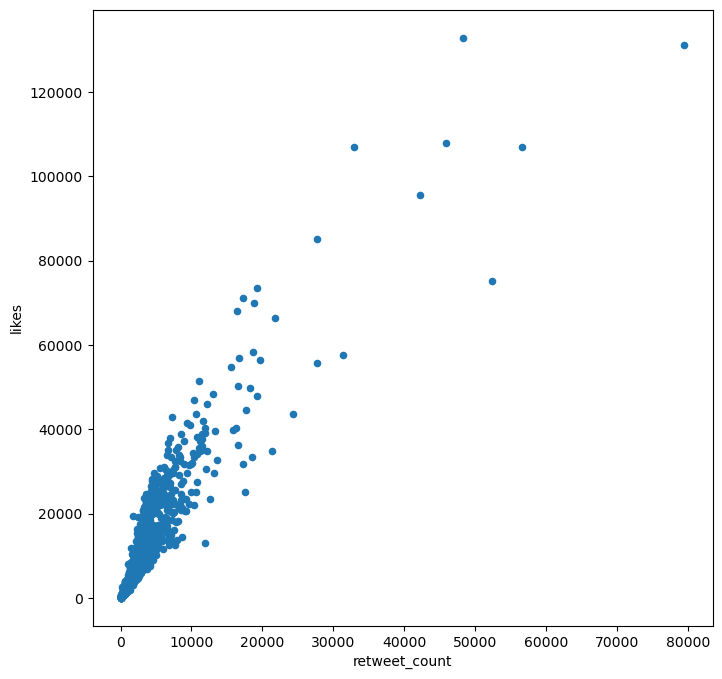

In [108]:
df.plot(x = 'retweet_count', y='likes', kind='scatter', figsize=(8,8));

#### Observation
Based on the scatter plot above, there seems to be a fairfly positive relationship between retweet counts and number of likes.

##### 3. What hours of the day have the highest and lowest tweets?

In [109]:
# Add hour column to the dataframe
df['hour'] = pd.to_datetime(df.timestamp).dt.hour

In [110]:
# Create hours data
hour_count = df.hour.value_counts().sort_index(ascending=True)

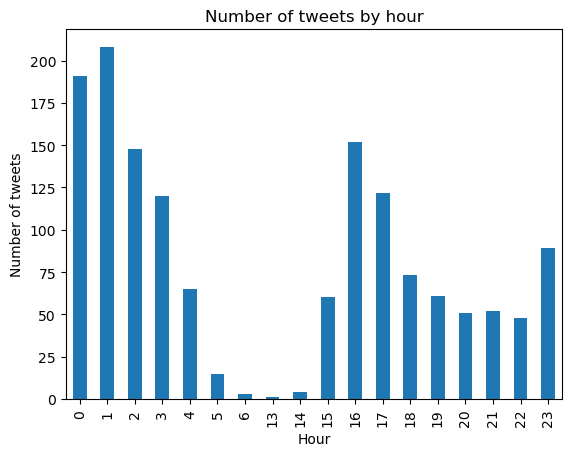

In [111]:
# Plot tweet count by hour of day
hour_count.plot(x='hour', y='tweet_count', kind='bar')
plt.title("Number of tweets by hour")
plt.xlabel("Hour")
plt.ylabel("Number of tweets");

#### Observation
By the plot above, midnight has the highest number of tweets. The tweets reduce consistently until afternoon and pick up in the evening starting at 4PM.

In [112]:
analysis_df = df.groupby('hour')[['retweet_count', 'likes']].sum()
analysis_df

,retweet_count,likes
hour,,
0,774782,2846168
1,504817,1720243
2,249257,701513
3,179764,522370
4,82792,238663
5,25387,58358
6,59236,114389
13,409,749
14,7591,27981


##### 4. Finding how many retweets and likes per tweet, depending on the hour of the day

In [113]:
analysis_df['likes_to_retweets'] = analysis_df.likes / analysis_df.retweet_count

In [114]:
analysis_df['tweets_per_hr'] = df['hour'].value_counts().sort_index()

In [115]:
analysis_df['retweets_per_tweet'] = analysis_df.retweet_count / analysis_df.tweets_per_hr

In [116]:
analysis_df['likes_per_tweet'] = analysis_df.likes / analysis_df.tweets_per_hr

In [117]:
analysis_df

,retweet_count,likes,likes_to_retweets,tweets_per_hr,retweets_per_tweet,likes_per_tweet
hour,,,,,,
0,774782,2846168,3.673508,191,4056.450262,14901.403141
1,504817,1720243,3.407657,208,2427.004808,8270.399038
2,249257,701513,2.814416,148,1684.168919,4739.952703
3,179764,522370,2.905865,120,1498.033333,4353.083333
4,82792,238663,2.882682,65,1273.723077,3671.738462
5,25387,58358,2.298736,15,1692.466667,3890.533333
6,59236,114389,1.931072,3,19745.333333,38129.666667
13,409,749,1.831296,1,409.000000,749.000000
14,7591,27981,3.686076,4,1897.750000,6995.250000


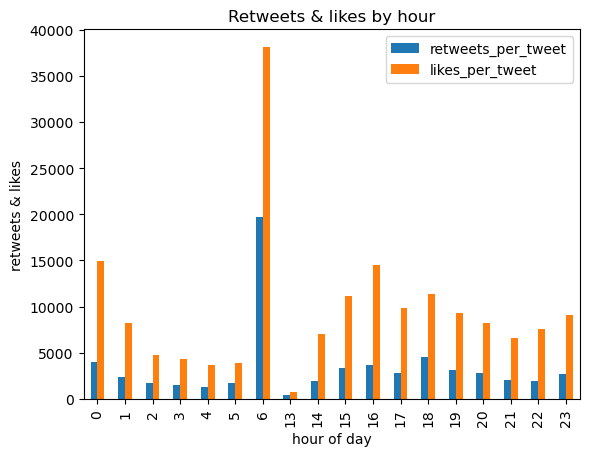

In [118]:
analysis_df.plot(y=['retweets_per_tweet', 'likes_per_tweet'], kind='bar')
plt.title('Retweets & likes by hour')
plt.ylabel('retweets & likes')
plt.xlabel('hour of day');

#### Observation
We can see that 6PM has the highest number of retweets and likes per tweet. Therefore 6PM has got the highest engagement during the day.

##### 5. What percentage of ratings were over 10 compared to those that were 10?

In [119]:
over_ten = df.query("numerator > 10").shape[0] / df.shape[0]

In [120]:
ten = df.query("numerator == 10").shape[0] / df.shape[0]

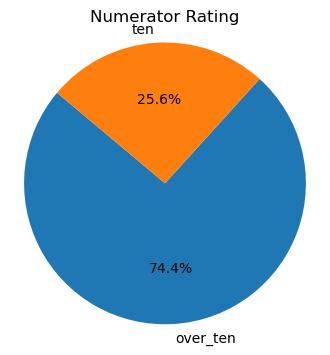

In [121]:
sizes = [over_ten, ten]
labels = ['over_ten', 'ten']
plt.figure(figsize=(4, 4))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('Numerator Rating')
plt.show()

##### Observation
The majority of ratings are more than the standard denominator of 10. Only 25.6% of numerators are equal to 10